# LDA( Collapsed Gibbs sampleing, cgs)による実装
---
LDAの実装をスクラッチでしてみた．ハイパーパラメータ($\alpha,\beta$は全て共通）  
10iterationに40分程度かかってるから使い物にならない..??

In [1]:
% matplotlib inline
import numpy as np
import scipy.special as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import copy
import time

In [2]:
# 必要なテーブルを読み込み
order = pd.read_csv("/Users/TakayukiYagi/Developer/M1/competition/data/order.csv")
detail = pd.read_csv("/Users/TakayukiYagi/Developer/M1/competition/data/order_detail.csv")
item = pd.read_csv("/Users/TakayukiYagi/Developer/M1/competition/data/item.csv")

# 必要な列だけ取り出し
df = pd.merge(pd.merge(order, detail, on='order_id', how='left'), item, on='item_id', how='left')[['customer_id', 'item_category_1']].dropna()

print(u'unique user数 : ', len(set(df.customer_id)), u'人')
print(u'カテゴリの種類 : ', len(set(df.item_category_1)), u'種類')

unique_customer_id = set(df.customer_id)
dict_customer_id = dict(zip(list(unique_customer_id), [i for i in range(len(unique_customer_id))]))

df.customer_id= df.customer_id.apply(lambda x: dict_customer_id[x])
df.head(5)

unique user数 :  101491 人
カテゴリの種類 :  25 種類


,customer_id,item_category_1
0,5493,雑貨/ホビー/スポーツ
1,5493,雑貨/ホビー/スポーツ
2,5493,雑貨/ホビー/スポーツ
3,5493,雑貨/ホビー/スポーツ
4,5493,雑貨/ホビー/スポーツ


In [3]:
X = df.as_matrix()

dictionary = {}  # カテゴリの記号化
item_per_cus = {} # 顧客ごとの購入商品

count = 0
for i in range(len(X)):
    if X[i][1] not in dictionary:
        dictionary[X[i][1]] = count
        count += 1
    if X[i][0] not in item_per_cus:
        item_per_cus[X[i][0]] = [dictionary[X[i][1]]]
    else:
        item_per_cus[X[i][0]].append(dictionary[X[i][1]])

# dictionary を表示
for (v, i) in dictionary.items():
    print(i," : ",  v)

13  :  アンダーウェア
23  :  音楽/本・雑誌
12  :  マタニティ・ベビー
3  :  インテリア
21  :  水着/着物・浴衣
7  :  ワンピース
18  :  ヘアアクセサリー
0  :  雑貨/ホビー/スポーツ
6  :  スカート
11  :  ジャケット/アウター
24  :  スーツ/ネクタイ
19  :  時計
9  :  ファッション雑貨
4  :  食器/キッチン
8  :  財布/小物
1  :  トップス
22  :  その他
2  :  パンツ
15  :  シューズ
5  :  帽子
16  :  バッグ
20  :  オールインワン・サロペット
10  :  アクセサリー
17  :  コスメ/香水
14  :  レッグウェア


In [4]:
tmp = list(item_per_cus.values())
min = 10  # 最低購入点数
max = 100 # 最大購入点数

# 購入点数でフィルタリング（min <= 購入点数 <= max のみ採用)
N = []
w_dn = []
for i in range(len(tmp)):
    n = len(tmp[i])
    if max >=n >= min:
        N.append(n)
        w_dn.append(tmp[i])

In [5]:
D = len(w_dn) # 顧客数 
K = 15 # トピック数
V = len(dictionary) # 商品数

ITE_NUM = 10
alpha = 2
beta = 2
theta_dk= np.zeros((D, K))
phi_kv = np.zeros((K, V))

In [6]:
# カウントを初期化 (N_dk = N_kv = N_k = 0)
N_dk = np.zeros((D, K)).astype(np.integer) # 顧客dで潜在クラスkが割り当てられた商品数
N_kv = np.zeros((K, V)).astype(np.integer) # 潜在クラスkに割り当てられた語彙vの単語数
N_k = np.zeros(K).astype(np.integer) # 潜在クラスkに割り当てられた商品数

# トピックを初期化 (z_dn = 0)
z_dn = copy.deepcopy(w_dn)
for i in range(len(z_dn)):
    z_dn[i] = list(map(lambda x: x*0-1, z_dn[i]))

# p(z_dn=k)を初期化
p_k = np.zeros(K)

# 関数を定義

def get_zdn(d, n, alpha, beta):
    # p(z_dn=k)を初期化
    p_k = np.zeros(K)
    # サンプリング確率を計算
    for k in range(K):
        p_k[k] =  (N_dk[d][k] + alpha)*(N_kv[k][w_dn[d][n]] + beta)/(N_k[k] + beta*V)
    p_k /= sum(p_k)
    # 潜在クラスをサンプリング
    topic = int(np.argmax(np.random.multinomial(1, p_k)))
    return topic # ディガンマ関数
def dig(x):
    return sp.psi(x)

# alphaの更新
def new_alpha():
    child = 0 # 分子を初期化
    mother = 0 # 分母を初期化
    for d in range(D):
        mother += K*dig(N[d] + alpha*K)
        for k in range(K):
            child += dig(N_dk[d][k] + alpha)
    mother -= D*K*dig(alpha*K)
    child -= D*K*dig(alpha)
    new_alpha = alpha*child/mother
    return new_alpha

# betaの更新
def new_beta():
    child = 0
    mother = 0
    for k in range(K):
        mother += V*dig(N_k[k] + beta*V)
        for v in range(V):
            child += dig(N_kv[k][v] + beta)
    mother -= K*V*dig(beta*V)
    child -= K*V*dig(beta)
    new_beta = beta*child/mother
    return new_beta

In [7]:
# main
start = time.time()
for i in range(ITE_NUM):
    for d in range(D):
        for n in range(N[d]):
            if z_dn[d][n] > -1:
                # カウントからz_dnの割当分を引く
                N_dk[d][z_dn[d][n]] -= 1
                N_kv[z_dn[d][n]][w_dn[d][n]] -= 1
                N_k[z_dn[d][n]] -= 1

            # z_dnをサンプリング
            z = get_zdn(d, n, alpha, beta)
            z_dn[d][n] = z

            # カウントに新たに割り当てられたトピック分を加える
            N_dk[d][z] += 1
            N_kv[z][w_dn[d][n]] += 1
            N_k[z] += 1

    # ハイパーパラメータを更新
    alpha = new_alpha()
    beta = new_beta()

for d in range(D):
    for k in range(K):
        theta_dk[d][k] = (N_dk[d][k] + alpha)/(N[d] + alpha*K)

for k in range(K):
    for v in range(V):
        phi_kv[k][v] = (N_kv[k][v] + beta)/(N_k[k] + beta*V)

finish = time.time()
a = finish - start

d, tmp = a//86400, a%86400
h, tmp = tmp//3600, tmp%3600
m, s = tmp//60, tmp%60
print("{0}day, {1}hour, {2}minute, {3}second".format(round(d), round(h), round(m), round(s)))

passed : 2267.988187789917 (s)


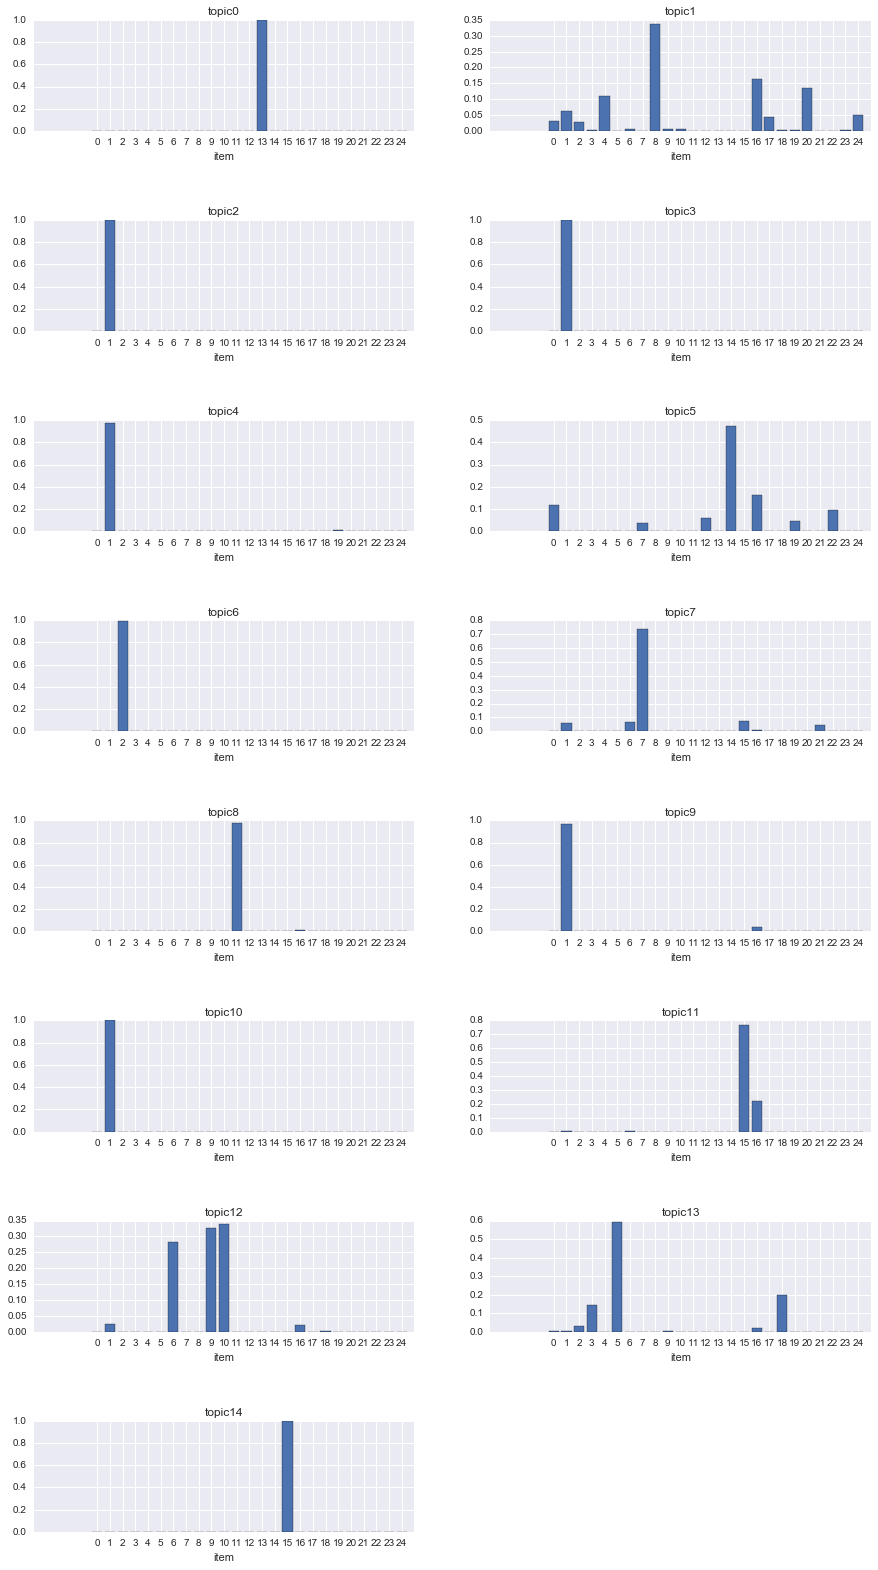

In [8]:
plt.figure(figsize=(15, 30))
plt.subplots_adjust(hspace=0.8, bottom=0.2)
for k in range(K):
    plt.subplot(int(K/2)+1, 2, k+1)
    plt.title('topic%d' %k)
    plt.bar(np.arange(V), phi_kv[k], align="center")
    plt.xlabel('item')
    plt.xticks(np.arange(V))
plt.savefig('cgs_1b.png')

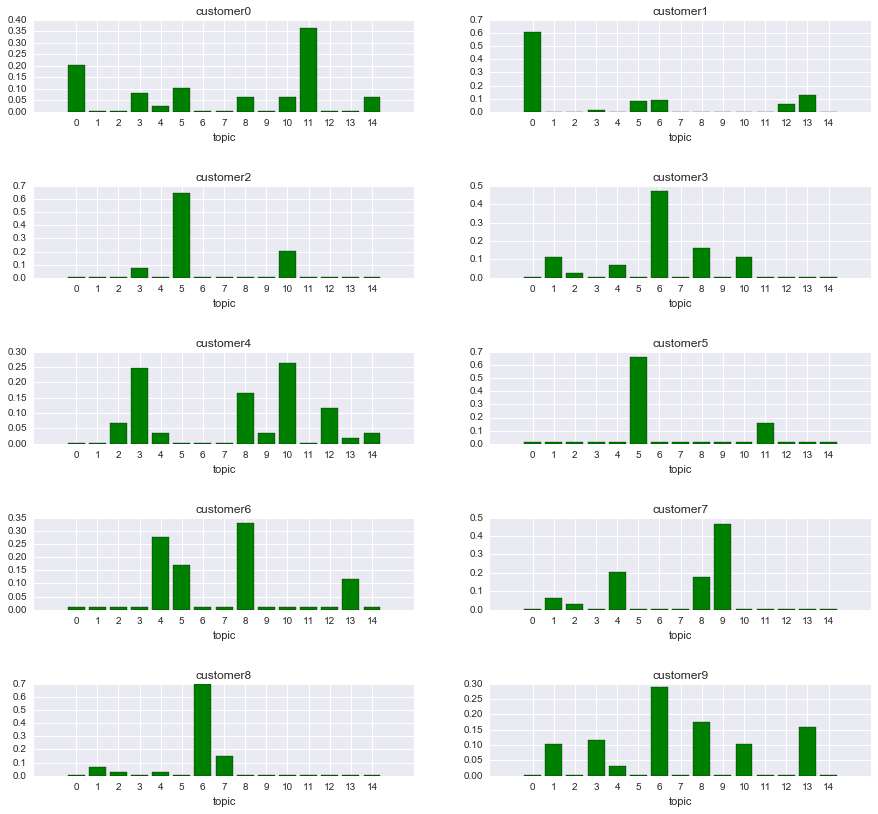

In [9]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.8, bottom=0.2)
for d in range(10):
    plt.subplot(5, 2, d+1)
    plt.title('customer%d' %d)
    plt.bar(np.arange(K), theta_dk[d], color='g', align="center")
    plt.xlabel('topic')
    plt.xticks(np.arange(K))